In [26]:
################################
# Scientific imports
################################
import matplotlib.pyplot as plt
import numpy as np

from astroquery.mast import Observations
from astroquery.mast import Catalogs

from astropy.table import Table
from astropy.table import QTable
from astropy.io import fits
from astropy import units as u
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import TimeSeries
from astropy.stats import sigma_clipped_stats
from astropy.timeseries import aggregate_downsample

import scipy
from scipy.signal import butter,filtfilt

import sktime as skt

from sktime.datatypes._panel._convert import (
    from_2d_array_to_nested,
    from_nested_to_2d_array,
    is_nested_dataframe,
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

################################
# General imports
################################
import csv, math, io, os, os.path, sys, random, time, json, gc
from datetime import datetime
import pandas as pd
import seaborn as sb
from collections import Counter
import joblib
from joblib import Parallel, delayed, dump, load

################################
# Suppress Warnings
################################
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

################################
# Initialisers
################################
default_rc_params = (16,5)
plt.rcParams["figure.figsize"] = default_rc_params
sb.set()

# Load the Data files
fitsarr = np.load("fitslist.npy")

In [27]:
def DrawLC(rndFile=-1):
    
    # rndFile is random, unless specified
    rndFile = random.randint(0,len(fitsarr)) if rndFile==-1 else rndFile
    
    # Get LC data from the requisite fits file
    fitsFile = fitsarr[rndFile]

    # The following line of code gives us the header values
    fitsHeaders = fits.getheader(fitsFile)

    with fits.open(fitsFile, mode="readonly") as hdulist:

        # Extract stellar parameters from the primary header.  We'll get the effective temperature, surface gravity,
        # and TESS magnitude.
        star_teff = hdulist[0].header['TEFF']
        star_logg = hdulist[0].header['LOGG']
        star_tmag = hdulist[0].header['TESSMAG']
        obj       = hdulist[0].header['OBJECT']
        sector    = hdulist[0].header['SECTOR']


        # Extract some of the columns of interest for the first TCE signal.  These are stored in the binary FITS table
        # in the first extension.  We'll extract the timestamps in TBJD, phase, initial fluxes, and corresponding
        # model fluxes.
        tess_bjds     = hdulist[1].data['TIME']
        sap_fluxes    = hdulist[1].data['SAP_FLUX']
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

    # X- and Y- labels
    ylab = "PDCSAP Flux (e-/s)"
    xlab = "Time (TBJD)"

    #ax.plot(tess_bjds[1:-1], pdcsap_fluxes[1:-1], 'k.', markersize=1)
    return (tess_bjds[1:-1], pdcsap_fluxes[1:-1], str(rndFile), str(obj), str(sector), ylab, xlab)



Text(0, 0.5, 'PDCSAP Flux (e-/s)')

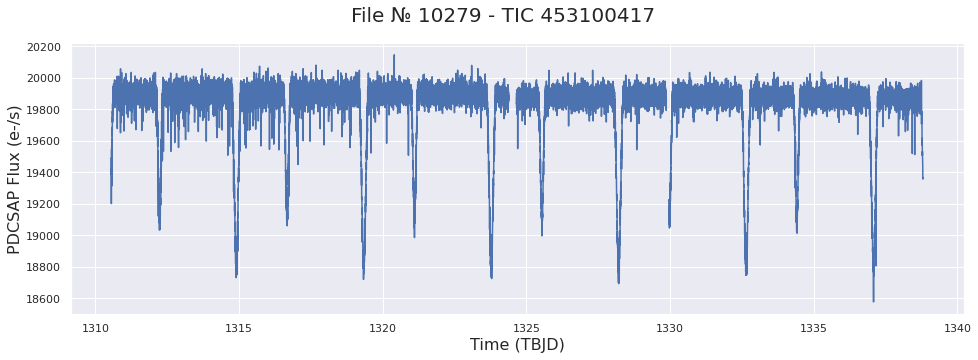

In [28]:
x,y,f,o,s,ylab,xlab = DrawLC(10279)

fig, ax = plt.subplots()

ax.plot(x,y)

fig.suptitle("File № {} - {}".format(f, o), fontsize=20) # + str(obj) + " - Sector " + str(sector))

ax.set_xlabel(xlab, fontsize=16)
ax.set_ylabel(ylab, fontsize=16)

## THE FUNCTIONS ARE BELOW

In [29]:
def FilterMyData(x, y):
    
    # Re-make the X and Y arrays
    dt      = np.diff(x)[0]
    betterX = np.arange(min(x), max(x), dt)                  # For some reason, x has NaNs in it, this makes a new, linear x scale
    betterY = y.copy()                                             # I dont think I need this here? As it's in a fn and so therefore local
    betterY[np.isnan(x)] = np.median(y)                      # Change all the missing values to the median value of the whole array
    
    # Frequency Data Stuff
    sec           = (max(betterX)-min(betterX))*24*60*60     # Number of seconds in the overall observation period
    freq          = len(betterX)/sec                         # Frequency, in Hz, ie number of observations per second
    cutoff        = 0.1*freq                                 # HYPERPARAMETER MAYBE???????? (has to be 0 < cutoff < 0.5 because of how normal cutoff works)
    
    order         = 2                                        # Approximation via polynomial of the order'th degree (2=quadratic, 3=cubic, 4=quartic, etc)
    
    # Butter Lowpass Filter
    nyq           = 0.5 * freq
    normal_cutoff = cutoff / nyq
    b, a          = butter(order, normal_cutoff, btype='low', analog=False)
    newY          = filtfilt(b, a, betterY)
    
    # Finally, return the new X and Y values
    return (betterX, newY)


In [39]:
def Every_Nth_Value(x,y,n):
    return (x[::n], y[::n])

## THE FUNCTIONS ARE ABOVE

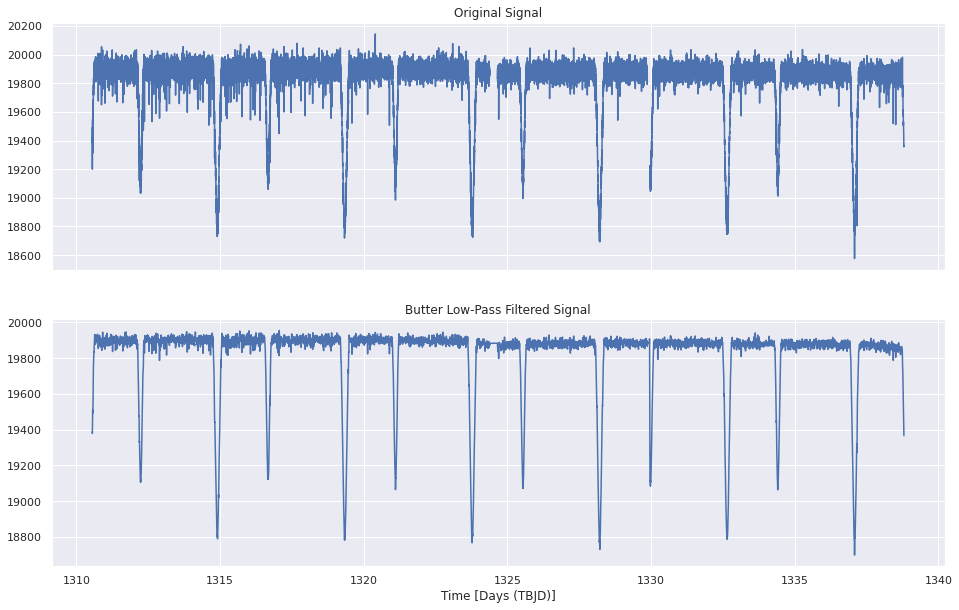

In [68]:
nX, nY = FilterMyData(x,y)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

plt.rcParams["figure.figsize"] = (16,10)

ax1.plot(x,y)
ax1.set_title('Original Signal')

ax2.plot(nX,nY)
ax2.set_title('Butter Low-Pass Filtered Signal')
ax2.set_xlabel('Time [Days (TBJD)]')

#plt.tight_layout()
plt.show()

In [70]:
plt.rcParams["figure.figsize"] = default_rc_params

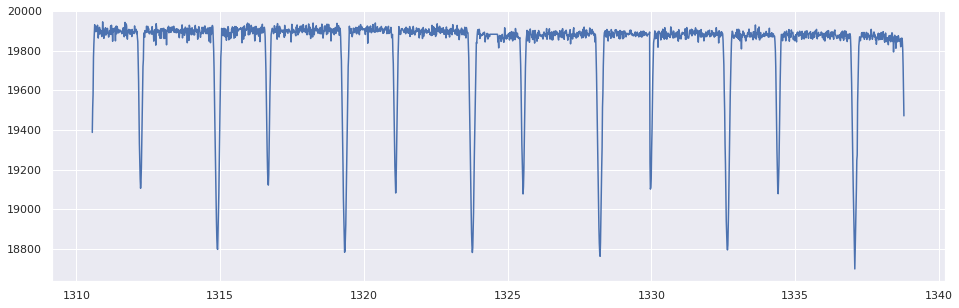

In [62]:
shortX, shortY = Every_Nth_Value(nX, nY, 10)

plt.plot(shortX,shortY)

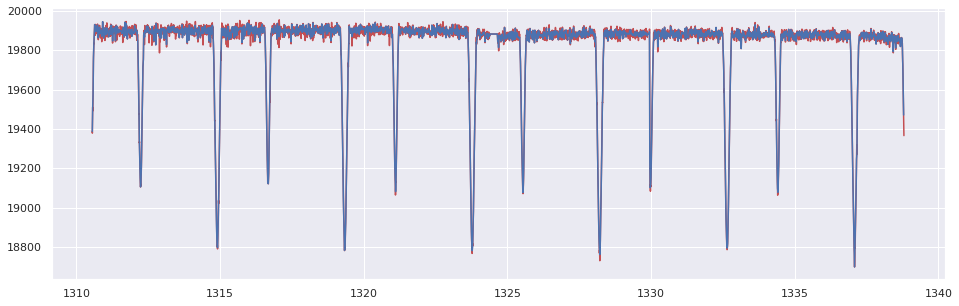

In [63]:
plt.plot(nX,nY,'r-')
plt.plot(shortX, shortY, 'b-')

### I'd say that's a cracking success!
(In above graph, Low-Pass Filtered signal shown in red; subsampled signal shown in blue, overlayed)

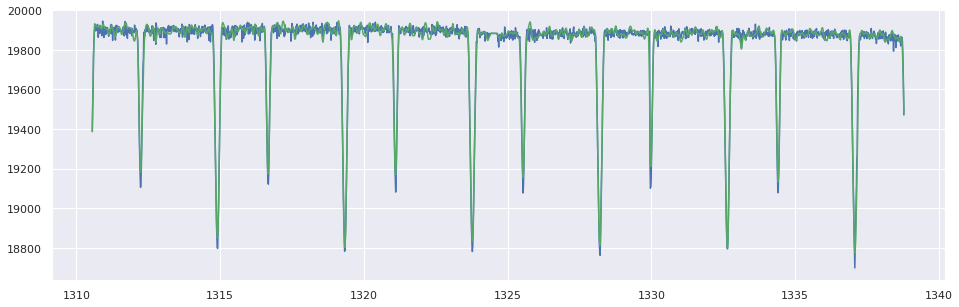

In [64]:
zX, zY = Every_Nth_Value(x,y,10)
zzX, zzY = FilterMyData(zX, zY)

plt.plot(shortX, shortY, 'b-')
plt.plot(zzX, zzY, 'g-')

### It is better to apply the filter and *then* subsample, as opposed to the other way around!
(Note missing tips from some of the valleys!)  
(In above graph, Filtered > Shortened signal shown in blue; Shortened > Filtered signal shown in green, overlayed)

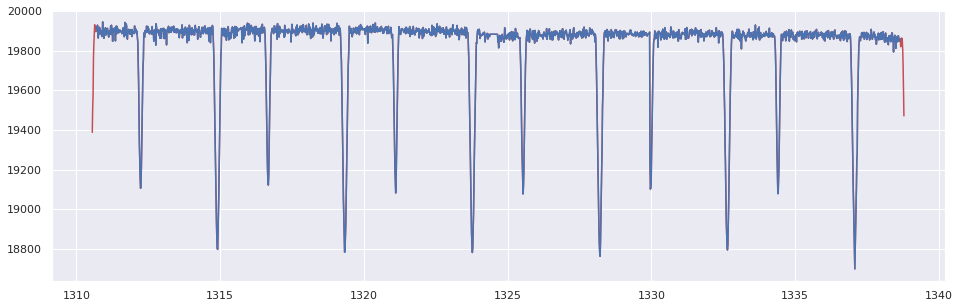

In [66]:
plt.plot(shortX, shortY, 'r-')
plt.plot(shortX[10:-10], shortY[10:-10], 'b-')

### Maybe take a windowed approach? Ignore first and last (say) 10 digits?
(In above graph, subsampled signal shown in red; 'windowed' signal shown in blue, overlayed)  
(Note the very edges are ignored, and everything else is the same, as expected)  